In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.nn as nn
import torchvision
import torch.optim as optim


import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import top_k_accuracy_score
from main import Xception, print_test_details, train_transform, test_transform


import json, os

In [2]:
# HYPERPARAMETERS

train_size = 0.8
test_size=0.2
cuda = 'cuda'
cpu = 'cpu' 
device = cuda if torch.cuda.is_available() else cpu


In [3]:
with open("mapping.json", 'r') as f:
    mapping = json.load(f)
    


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate= (.15, .15), scale = (0.85, 1.15)),

    transforms.Resize(324), #Resize data to be 224x224.
    transforms.RandomCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.Resize((324, 324)),
    transforms.TenCrop((299, 299)),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(x) for x in crops]))
    ])




In [4]:

class myDataset(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x, y = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x, y
   


In [6]:

full_dataset = torchvision.datasets.ImageFolder(
    root='./dataset',
    transform=None
)

train, test = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))

train_dataset = myDataset(train, transform=train_transform)
test_dataset = myDataset(test, transform=test_transform)

batch_size=32

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True, 
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False   
)   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7882353..0.4666667].


label: fighter-jet (index - 69)


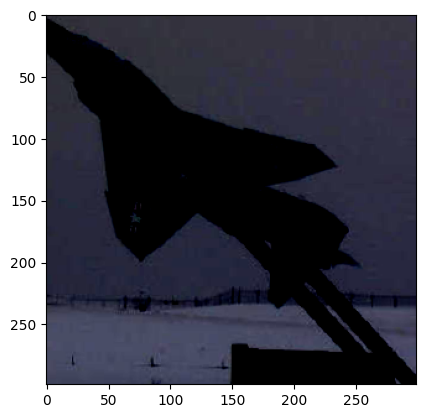

In [7]:
#visualize an image from train_dataset

i = 1135

image = train_dataset[i][0].permute(1, 2, 0).numpy()
label = mapping[str(train_dataset[i][1]+1)] #+1 is required, because the "class 1" in folders, is class 0 when torch loads it

print(f"label: {label} (index - {train_dataset[i][1]+1})")
plt.imshow(image)

In [8]:
class BNConv2D(nn.Module):

    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride = 1,
            padding= 0,
            dilation=1,
            groups=1,
    ):
        super().__init__()

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)


    def forward(self, X):
        
        out = self.conv(X)
        out = self.bn(out)

        return out
    
class BN_DepthwiseSeparableConv2D(nn.Module):

    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride = 1,
            padding= 0,
            dilation=1,
    ):
        super().__init__()

        self.depthwise_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels, 
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,
            bias=False
        )
        self.pointwise_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, X):

        out = self.depthwise_conv(X)
        out = self.pointwise_conv(out)
        out = self.bn(out)

        return out

class MiddleFlow(nn.Module):

    def __init__(self, channels:int=512):
        super().__init__()

        self.flow = nn.Sequential(
            nn.ReLU(), BN_DepthwiseSeparableConv2D(channels, channels, 3, 1, 1),
            nn.ReLU(), BN_DepthwiseSeparableConv2D(channels, channels, 3, 1, 1),
            nn.ReLU(), BN_DepthwiseSeparableConv2D(channels, channels, 3, 1, 1)
        )

    def forward(self, X):

        out = self.flow(X)
        out += X
        return out

class Xception(nn.Module):
    """
    [paper](https://arxiv.org/pdf/1610.02357) from where this is implemented
    """

    def __init__(self, num_middle_layers:int=3):
        super().__init__()


        ## ENTRY FLOW
        self.block1_conv1 = BN_DepthwiseSeparableConv2D(in_channels=3, out_channels=32, stride=2, kernel_size=3)
        self.block1_conv2 = BN_DepthwiseSeparableConv2D(in_channels=32, out_channels=64, kernel_size=3)
        

        self.residual1 = BNConv2D(in_channels=64, out_channels=128, kernel_size=1, padding=0, stride=2)
        self.residual2 = BNConv2D(in_channels=128, out_channels=256, kernel_size=1, padding=0, stride=2)
        self.residual3 = BNConv2D(in_channels=256, out_channels=512, kernel_size=1, padding=0, stride=2)


        self.block2_conv1 = BN_DepthwiseSeparableConv2D(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.block2_conv2 = BN_DepthwiseSeparableConv2D(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        

        self.block3_conv1 = BN_DepthwiseSeparableConv2D(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.block3_conv2 = BN_DepthwiseSeparableConv2D(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.block4_conv1 = BN_DepthwiseSeparableConv2D(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.block4_conv2 = BN_DepthwiseSeparableConv2D(in_channels=256, out_channels=512, kernel_size=3, padding=1)


        
        ## MIDDLE FLOW
        channels = 512

        self.middle_layers = nn.ModuleList()

        for _ in range(num_middle_layers):
            
            self.middle_layers.append(MiddleFlow(channels=channels))


        ## EXIT FLOW


        self.exitblock1_conv1 = BN_DepthwiseSeparableConv2D(channels, 728, 3, padding=1)
        self.exitblock1_conv2 = BN_DepthwiseSeparableConv2D(728, 1024, 3, padding=1)





        self.last = nn.Linear(1024, 256)
        

        
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.max_pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()


    def forward(self, X):

        #block 1
        out = self.block1_conv1(X)
        out = self.relu(out)
        out = self.block1_conv2(out)
        out = self.relu(out)
        
        #block 2
        residual = self.residual1(out)

        out = self.block2_conv1(out)
        out = self.relu(out)
        out = self.block2_conv2(out)
        out = self.max_pooling(out)

        out += residual
        
        #block 3
        residual = self.residual2(out)

        out = self.relu(out)
        out = self.block3_conv1(out)
        out = self.relu(out)
        out = self.block3_conv2(out)
        out = self.max_pooling(out)

        out += residual

        #block 4
        residual = self.residual3(out)

        out = self.relu(out)
        out = self.block4_conv1(out)
        out = self.relu(out)
        out = self.block4_conv2(out)
        out = self.max_pooling(out)

        out += residual

        #middle flow
        for layer in self.middle_layers:
            residual = out
            out = layer(out)            
            out += residual


        ## EXIT flow
        out = self.exitblock1_conv1(out)
        out = self.exitblock1_conv2(out)
        out = self.global_avgpool(out)

        out = torch.flatten(out, 1)
        out = self.last(out)


        



        return out

        

In [9]:
model = Xception(5)


# model.load_state_dict(torch.load("xception_middle5_5.9M.pth"))


model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

In [10]:
# from main import print_test_details

In [11]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



In [12]:
count_trainable_parameters(model)

5920739

In [13]:
for epoch in range(5):

    start = time.time()
    total_training_loss = 0
    total_training_samples = 0
    total_training_correct_classfied = 0

    iteration_start =time.time()
    model.train()

    for iteration, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        output_predictions = model(images)

        loss_value = criterion(output_predictions, labels)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

        

        
        total_training_loss += loss_value.item()*labels.shape[0]
        total_training_samples += labels.shape[0]
        _, predicted = torch.max(output_predictions, dim=1)
        total_training_correct_classfied += (labels == predicted).sum().item()

        if iteration%250==0:
            print(f"iteration {iteration+1} done. time taken={time.time()-iteration_start}")
            iteration_start = time.time()

    print_text = f"epoch: {epoch+1}, train loss: {total_training_loss/ total_training_samples}, train accuracy: {total_training_correct_classfied/total_training_samples}, time taken: {time.time()-start}"
    

    print(f"epoch: {epoch+1}, train loss: {total_training_loss/ total_training_samples}, train accuracy: {total_training_correct_classfied/total_training_samples}, time taken: {time.time()-start}")

    # if (epoch-1)%3==0:
    #     print_test_details(model, criterion, test_loader)   
    print()





iteration 1 done. time taken=2.8433525562286377
iteration 251 done. time taken=476.1437339782715
iteration 501 done. time taken=473.4329345226288
epoch: 1, train loss: 4.766490696739878, train accuracy: 0.09696104768300873, time taken: 1396.4631235599518

iteration 1 done. time taken=1.7254812717437744
iteration 251 done. time taken=453.8682231903076
iteration 501 done. time taken=457.0505998134613
epoch: 2, train loss: 4.189763304369013, train accuracy: 0.15396239086635324, time taken: 1352.135099887848

iteration 1 done. time taken=1.7601902484893799
iteration 251 done. time taken=447.69603180885315
iteration 501 done. time taken=472.84569478034973
epoch: 3, train loss: 3.883167616227395, train accuracy: 0.19266286098052385, time taken: 1373.9996666908264

iteration 1 done. time taken=1.8805875778198242


KeyboardInterrupt: 

In [ ]:
print(torch.cuda.memory_summary())

optim.Adam(model.parameters(), weight_decay=1e-5)


In [14]:
# model.to('cpu')
torch.save(model.state_dict(), "xception_middle5_5.9M.pth")

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)